# Modeling

### Import Relevant Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, snowball
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.util import ngrams
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder 
from nltk.util import ngrams

nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import plot_confusion_matrix, classification_report, r2_score, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\capta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read in Processed Data

In [2]:
df = pd.read_parquet('../Data/processed_reports.parquet')

In [3]:
df.reset_index(inplace=True)

In [4]:
df.drop(['index'],axis=1,inplace=True)

### Create secondary classification target 

In [5]:
df['target'] = df.Round

In [6]:
df.target[df.target >= 6] = 0

In [7]:
df.target[df.target == 1] = 10

In [8]:
df.target[(df.target == 4) | (df.target == 5)] = 1

In [9]:
df.target[df.target == 3] = 2

In [10]:
df.target[df.target == 10] = 3

In [11]:
cleaned_df = df.drop(['report','processed_report','joined_report','weight_y','height_y'],axis=1) 

In [12]:
# Add _col to each column to prevent duplicate naming when combining with the scouting report words
cleaned_df = cleaned_df.add_suffix('_col')

### Add grades and rankings for 2022 draft

In [13]:
grades22 = pd.read_excel('../Data/addgrades.xlsx')

In [14]:
cleaned_df.pos_rk_col[cleaned_df.year_col == 2022] = grades22.pos_rk_col
cleaned_df.ovr_rk_col[cleaned_df.year_col == 2022] = grades22.ovr_rk_col
cleaned_df.grade_col[cleaned_df.year_col == 2022] = grades22.grade_col

C:\Users\capta\AppData\Local\Temp\ipykernel_16992\2333570552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.pos_rk_col[cleaned_df.year_col == 2022] = grades22.pos_rk_col
C:\Users\capta\AppData\Local\Temp\ipykernel_16992\2333570552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.ovr_rk_col[cleaned_df.year_col == 2022] = grades22.ovr_rk_col
C:\Users\capta\AppData\Local\Temp\ipykernel_16992\2333570552.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

### TFIDF Vectorizing

In [15]:
tf = TfidfVectorizer(ngram_range=(1,3),min_df=.062,max_df =.75)

In [16]:
X = tf.fit_transform(df.joined_report)

In [17]:
report_df = pd.DataFrame(X.toarray(),columns=tf.get_feature_names())

### Merge TFIDF features with all other features

In [18]:
model_df = pd.concat([cleaned_df,report_df],axis=1)

### Count Vectorizer

In [19]:
# Alternative Data that uses CountVectorizer instead of TFIDF
cvec = CountVectorizer(ngram_range=(1,3),min_df=.062,max_df=.75)
X_cvec = cvec.fit_transform(df.joined_report)
cvec_df = pd.DataFrame(X_cvec.toarray(),columns=cvec.get_feature_names())
cvec_model_df = pd.concat([cleaned_df,cvec_df],axis=1)

### Remove First Round Players with no Overall Rank

In [21]:
cvec_model_df.drop(index=[1815,2770],inplace=True)
model_df.drop(index=[1815,2770],inplace=True)

### Modeling Functions

In [22]:
def get_model_results (model):

    # Fit GridSearch for model
    model.fit(X_train,y_train)

    # Get y_preds
    y_pred = model.predict(X_test)

    # Set metric scores with print labels
    r2 = f"r2 = {round(r2_score(y_test,y_pred),4)}"
    MSE = f"MSE = {round(mean_squared_error(y_test,y_pred),2)}"
    
    return r2, MSE

In [23]:
def graph_model_results(model):
    
    y_pred = model.predict(X_test)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.regplot(x=y_pred,y=y_test,line_kws={"color": "red"})
    plt.xlabel('Predicted Pick')
    plt.ylabel('Pick')
    plt.title('Actual Pick vs. Model Predicted Pick')
    plt.xlim(-5,265)
    plt.ylim(-5,265)
    plt.annotate(f'r2 = {round(r2_score(y_test,y_pred),3)}',xy=(230,240));
    return

### Linear Regression

In [24]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('lin',LinearRegression())
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
}

# GridSearch with Cross Validation of 5
lin = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [25]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(lin))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

('r2 = 0.5504', 'MSE = 2264.27')
0.0 minutes


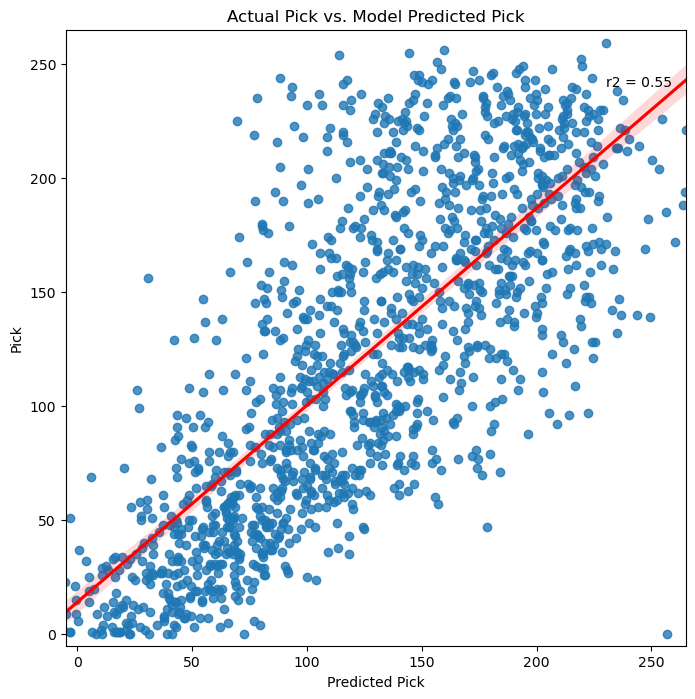

In [26]:
# Graph model results
graph_model_results(lin)

### Random Forest

In [27]:
# Set X and y
X = cvec_model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(cvec_model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
rfc_pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('forest',RandomForestRegressor())
])

# Fit model
rfc_pipe.fit(X_train, y_train)

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'forest__n_estimators':[102],
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'forest__max_depth':[24],
    'forest__min_samples_split':[2],
    'forest__min_samples_leaf':[6]
}

# GridSearch with Cross Validation of 5
cvec_forest = GridSearchCV(estimator=rfc_pipe,
                          param_grid=grid,
                          cv=5)

In [28]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(cvec_forest))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

('r2 = 0.6857', 'MSE = 1583.08')
1.5 minutes


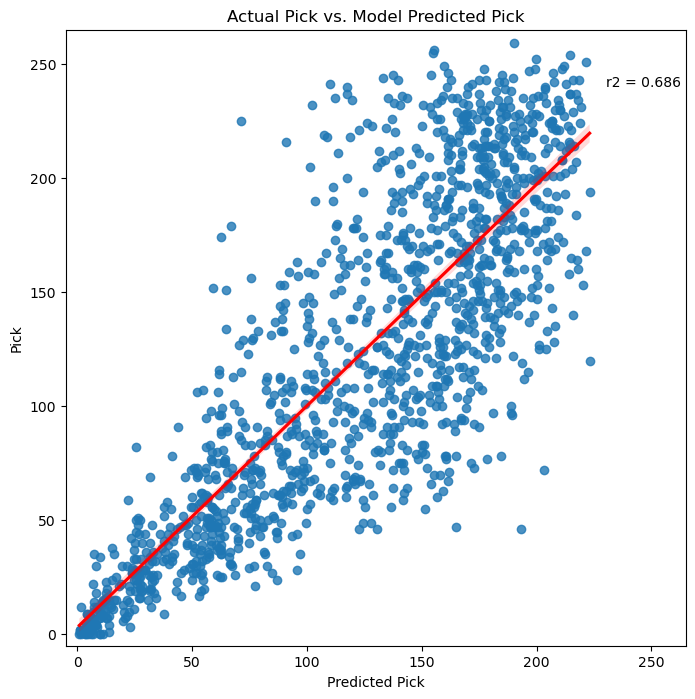

In [29]:
# Graph model results
graph_model_results(cvec_forest)

In [30]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
rfc_pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('forest',RandomForestRegressor())
])

# Fit model
rfc_pipe.fit(X_train, y_train)

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'forest__n_estimators':[102],
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'forest__max_depth':[24],
    'forest__min_samples_split':[2],
    'forest__min_samples_leaf':[6]
}

# GridSearch with Cross Validation of 5
forest = GridSearchCV(estimator=rfc_pipe,
                          param_grid=grid,
                          cv=5)

In [31]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(forest))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

('r2 = 0.6807', 'MSE = 1608.03')
2.1 minutes


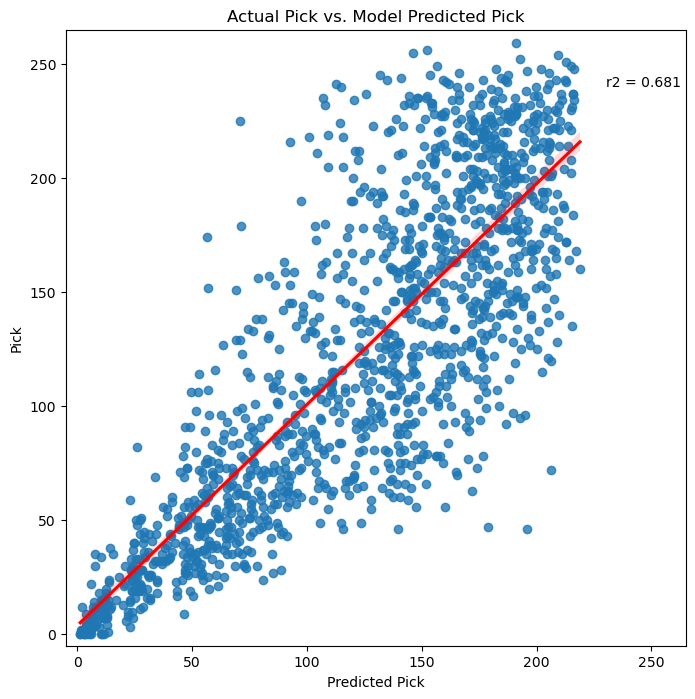

In [32]:
# Graph model results
graph_model_results(forest)

### Get Weights from Random Forest Model

In [33]:
# Get names of the OneHotEncoded Columns
rfc_pipe[0].transformers_[1][1].named_steps['ohe'].get_feature_names()

array(['x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain East Conference', 'x0_Mountain West Conference',
       'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelve Conference', 'x0_Patriot League',
       'x0_Pennsylvania State Athletic Conference',
       '

In [34]:
# Get all the other X_train columns
X_train.columns.to_list()

['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col'

In [35]:
# Combine the X_train columns and the OneHotEncoded problems in the proper order
# EXTREMELY important as otherwise the feature names will be mismatched
feature_cols = ['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col',
 'rec_yds_season_col',
 'rec_yds_per_rec_season_col',
 'scrim_att_season_col',
 'scrim_yds_season_col',
 'scrim_yds_per_att_season_col',
 'scrim_td_season_col',
 'rush_att_career_col',
 'rush_yds_career_col',
 'rush_yds_per_att_career_col',
 'rush_td_career_col',
 'rec_career_col',
 'rec_yds_career_col',
 'rec_yds_per_rec_career_col',
 'rec_td_career_col',
 'scrim_att_career_col',
 'scrim_yds_career_col',
 'scrim_yds_per_att_career_col',
 'scrim_td_career_col',
 'fumbles_rec_yds_career_col',
 'fumbles_rec_td_career_col',
 'rec_td_season_col',
 'def_int_td_season_col',
 'def_int_td_career_col',
 'fumbles_rec_career_col',
 'fumbles_rec_yds_season_col',
 'fumbles_rec_td_season_col',
 'fumbles_rec_season_col',
 'tackles_solo_season_col',
 'tackles_assists_season_col',
 'tackles_total_season_col',
 'tackles_loss_season_col',
 'sacks_season_col',
 'pass_defended_season_col',
 'tackles_solo_career_col',
 'tackles_assists_career_col',
 'tackles_total_career_col',
 'tackles_loss_career_col',
 'sacks_career_col',
 'pass_defended_career_col',
 'fumbles_forced_season_col',
 'fumbles_forced_career_col',
 'x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelve Conference', 'x0_Patriot League',
       'x0_Pennsylvania State Athletic Conference',
       'x0_Pioneer Football League', 'x0_South Atlantic Conference',
       'x0_Southeastern Conference', 'x0_Southern Conference',
       'x0_Southern Intercollegiate Athletic Conference',
       'x0_Southland Conference', 'x0_Southwestern Athletic Conference',
       'x0_Sun Belt Conference', 'x0_Western Athletic Conference',
       'x0_Wisconsin Intercollegiate Athletic Conference','x0_None','speed_col',
 'shuttle_agility_col',
 'cone_agility_col','x1_DB', 'x1_DE', 'x1_DL', 'x1_DT', 'x1_FB', 'x1_K', 'x1_LB',
       'x1_LS', 'x1_OL', 'x1_P', 'x1_QB', 'x1_RB', 'x1_S', 'x1_TE',
       'x1_WR','2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2016',
 'abil',
 'adequ',
 'also',
 'appear',
 'arm',
 'athlet',
 'athlet abil',
 'athletic',
 'averag',
 'back',
 'backup',
 'ball',
 'ball skill',
 'best',
 'better',
 'big',
 'block',
 'blocker',
 'bodi',
 'burst',
 'career',
 'catch',
 'class',
 'close',
 'colleg',
 'combin',
 'come',
 'concern',
 'consist',
 'contribut',
 'corner',
 'could',
 'coverag',
 'day',
 'defend',
 'defens',
 'develop',
 'draft',
 'durabl',
 'earli',
 'edg',
 'effect',
 'eight',
 'elit',
 'end',
 'end speed',
 'enough',
 'excel',
 'experi',
 'explos',
 'field',
 'final',
 'finish',
 'first',
 'fit',
 'five',
 'flash',
 'flash abil',
 'footbal',
 'forc',
 'four',
 'frame',
 'freshman',
 'fumbl',
 'game',
 'get',
 'good',
 'grade',
 'great',
 'guard',
 'hand',
 'high',
 'howev',
 'ideal',
 'improv',
 'inconsist',
 'injuri',
 'insid',
 'instinct',
 'intercept',
 'job',
 'junior',
 'lack',
 'lack ideal',
 'last',
 'late',
 'left',
 'length',
 'level',
 'like',
 'limit',
 'line',
 'lineback',
 'long',
 'loss',
 'lot',
 'make',
 'man',
 'miss',
 'move',
 'much',
 'natur',
 'need',
 'nfl',
 'offens',
 'one',
 'outsid',
 'outstand',
 'overal',
 'pass',
 'pass rusher',
 'physic',
 'pick',
 'play',
 'play game',
 'player',
 'point',
 'posit',
 'possess',
 'potenti',
 'power',
 'pro',
 'product',
 'project',
 'prospect',
 'quarterback',
 'quick',
 'rang',
 'receiv',
 'record',
 'redshirt',
 'return',
 'right',
 'round',
 'round pick',
 'rout',
 'rout runner',
 'run',
 'run defend',
 'runner',
 'rush',
 'rusher',
 'sack',
 'safeti',
 'scheme',
 'season',
 'second',
 'senior',
 'set',
 'short',
 'show',
 'six',
 'size',
 'skill',
 'special',
 'special team',
 'speed',
 'start',
 'start game',
 'starter',
 'still',
 'strength',
 'strong',
 'tackl',
 'tackl loss',
 'take',
 'team',
 'techniqu',
 'term',
 'three',
 'three season',
 'tight',
 'time',
 'top',
 'top end',
 'top end speed',
 'total',
 'touchdown',
 'tough',
 'true',
 'true freshman',
 'two',
 'two season',
 'upsid',
 'valu',
 'versatil',
 'well',
 'work',
 'yard',
 'year',
 'year starter',
 'zone']

In [36]:
# Get the weight values of the Random Forest Model
weights = rfc_pipe[-1].feature_importances_

In [37]:
# Zip the names and the weights together into a DataFrame
coefs = pd.DataFrame(zip(feature_cols,weights))

### Sorted Results of the Weights of the Random Forest Model

In [38]:
coefs.sort_values(by=1,ascending=False).head(20)

,0,1
3,ovr_rk_col,0.602539
4,grade_col,0.102724
6,reportlen_col,0.007455
2,pos_rk_col,0.006506
84,x0_Atlantic Coast Conference,0.005567
86,x0_Big Sky Conference,0.004709
230,lack,0.004360
1,height_x_col,0.004323
85,x0_Big East,0.004207
0,weight_x_col,0.004006


### KNN

In [39]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('knn',KNeighborsRegressor())
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'knn__n_neighbors':[30,40]
#     'forest__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'forest__max_depth':[4,12,None],
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
knn = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [40]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(knn))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\

('r2 = 0.2437', 'MSE = 3808.69')
0.1 minutes


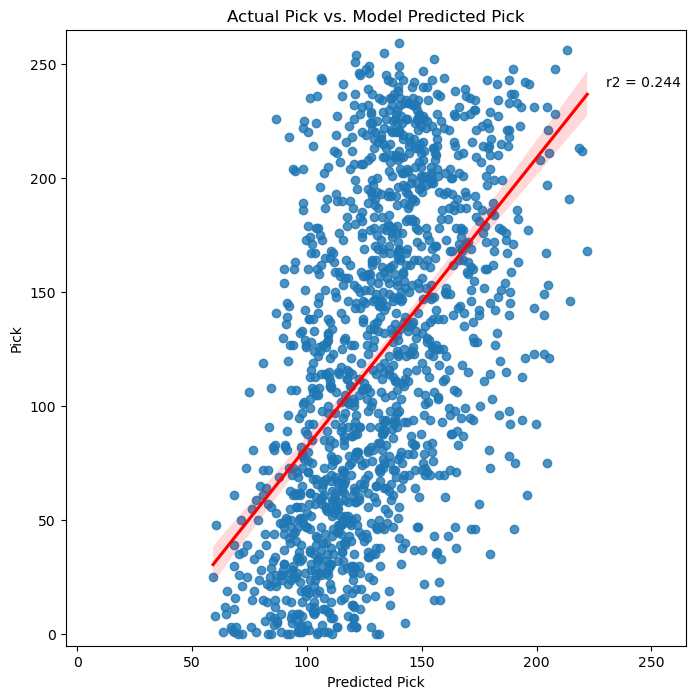

In [41]:
# Graph model results
graph_model_results(knn)

### Decision Tree

In [42]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('tree',DecisionTreeRegressor(random_state=42))
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)]
#     'tree__n_estimators':[75,100,125],
#     'tree__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#     'tree__max_depth':[4,12,None],
#     'tree__min_samples_split':[1,2,3],
#     'tree__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
tree = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [43]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(tree))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

('r2 = 0.4179', 'MSE = 2931.62')
0.1 minutes


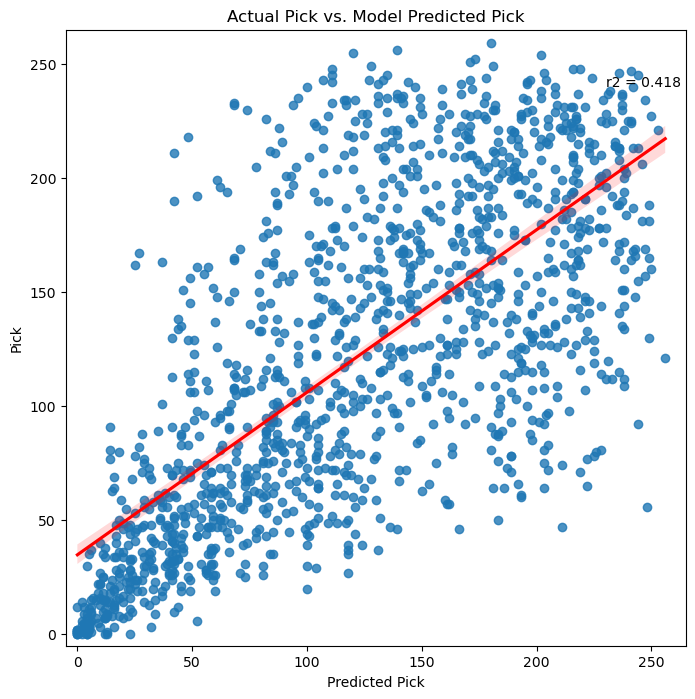

In [44]:
# Graph model results
graph_model_results(tree)

### XGBoost

In [45]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('xgb',XGBRegressor())
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'xgb__max_depth':[2,1],
    'xgb__eta':[.2,.22],
    'xgb__gamma':[0,.15]
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
xgb = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [46]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(xgb))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta

('r2 = 0.6765', 'MSE = 1629.34')
0.8 minutes


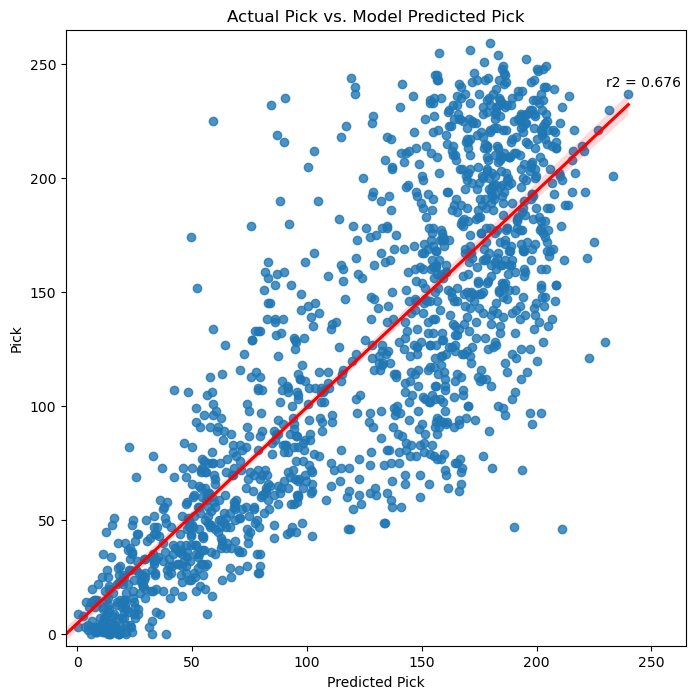

In [47]:
# Graph model results
graph_model_results(xgb)

### ADABoost

In [48]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('ada',AdaBoostRegressor(random_state=42))
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'ada__n_estimators':[42,40],
    'ada__learning_rate':[.35],
    'ada__loss':['linear','square','exponential']
#     'forest__min_samples_split':[1,2,3],
#     'forest__min_samples_leaf':[1,2,3]
}

# GridSearch with Cross Validation of 5
ada = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [49]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(ada))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta

('r2 = 0.6715', 'MSE = 1654.3')
2.2 minutes


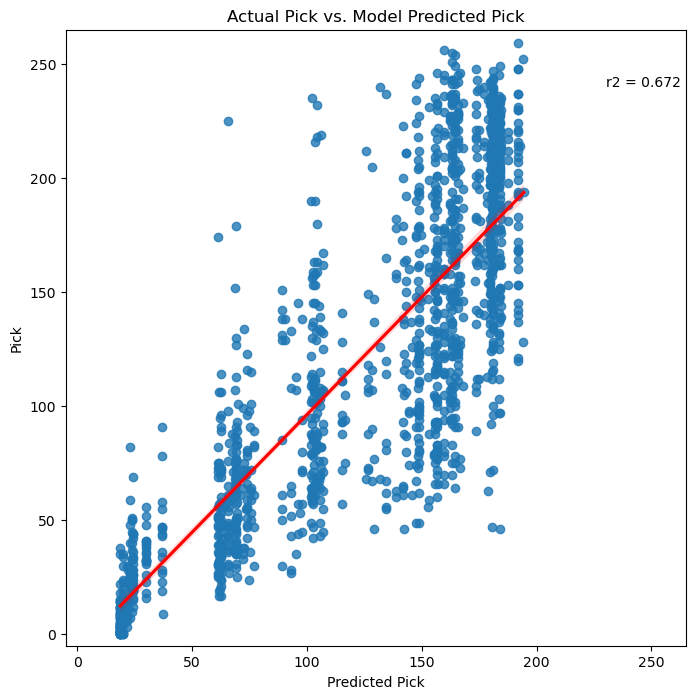

In [50]:
# Graph model results
graph_model_results(ada)

### GradientBoost

In [51]:
# Set X and y
X = model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('grad',GradientBoostingRegressor(random_state=42))
])

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'grad__n_estimators':[92],
    'grad__learning_rate':[.05],
#     'grad__loss':['absolute_error','squared_error','huber','quantile'],
    'grad__min_samples_split':[2],
    'grad__min_samples_leaf':[2],
    'grad__max_depth':[4],
    'grad__min_impurity_decrease':[.3]
}

# GridSearch with Cross Validation of 5
grad = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv=5)

In [52]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(grad))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

('r2 = 0.6849', 'MSE = 1587.09')
1.0 minutes


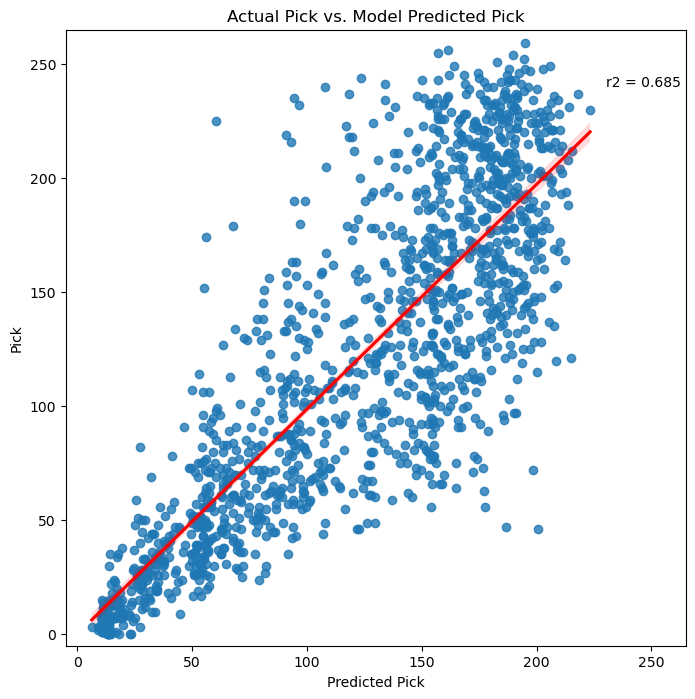

In [53]:
# Graph model results
graph_model_results(grad)

In [54]:
# Set X and y
X = cvec_model_df.drop(['Pick_col'],axis=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(cvec_model_df.Pick_col)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

# Save X_test columns to add to predictions after modeling
player_name = X_test.player_col
player_year = X_test.year_col
player_round = X_test.Round_col
player_target = X_test.target_col

# Drop unneeded or data leakage columns
X_train.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)
X_test.drop(['player_col','year_col','Round_col','target_col'],axis=1,inplace=True)

# Get numerical and categorical columns to breakup 
num_cols = X_train.select_dtypes(['Int64','float64'])
cat_cols = X_train.select_dtypes('object')

# Numerical transformer pipeline
num_transformer = Pipeline(steps=[('ss',StandardScaler()),
                             ('impute',SimpleImputer(strategy='constant'))])

# Categorical transformer pipeline
cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])

# Column transformer of numerical and categorical transformers
transformer = ColumnTransformer(transformers=[
    ('num',num_transformer,num_cols.columns),
    ('cat',cat_transformer,cat_cols.columns)
])

# Pipeline for transformations, sampling and the model
grad_pipe = Pipeline([
    ('transformer',transformer),
    ('sample',None),
    ('grad',GradientBoostingRegressor(random_state=42))
])

# Fit model
grad_pipe.fit(X_train, y_train)

# Create Grid for GridSearch
grid = {
    'sample':[RandomOverSampler(random_state=42),SMOTE(random_state=42)],
    'grad__n_estimators':[92],
    'grad__learning_rate':[.05],
#     'grad__loss':['absolute_error','squared_error','huber','quantile'],
    'grad__min_samples_split':[2],
    'grad__min_samples_leaf':[2],
    'grad__max_depth':[4],
    'grad__min_impurity_decrease':[.3]
}

# GridSearch with Cross Validation of 5
cvec_grad = GridSearchCV(estimator=grad_pipe,
                          param_grid=grid,
                          cv=5)

In [55]:
# Set start time
start_time = time.time()

# Call results function
print(get_model_results(cvec_grad))

# Return run time
print(round((time.time() - start_time)/60,1),'minutes')

# Set y_pred
y_pred = cvec_grad.predict(X_test)

C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\capta\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\capta\anaconda3\lib\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "C:\Users\capta\a

('r2 = 0.6864', 'MSE = 1579.22')
0.8 minutes


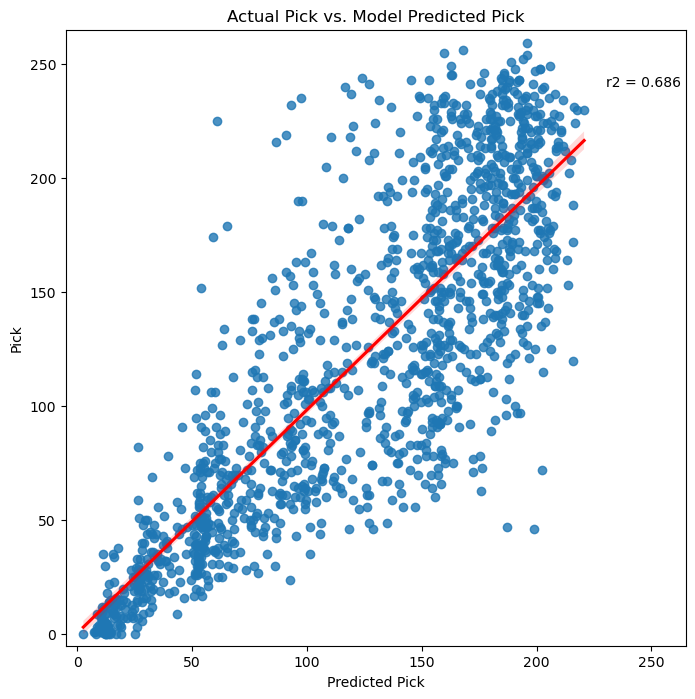

In [56]:
# Graph model results
graph_model_results(cvec_grad)

### Get Weights for Gradient Boost Model

In [57]:
# Get names of the OneHotEncoded Columns
grad_pipe[0].transformers_[1][1].named_steps['ohe'].get_feature_names()

array(['x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain East Conference', 'x0_Mountain West Conference',
       'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelve Conference', 'x0_Patriot League',
       'x0_Pennsylvania State Athletic Conference',
       '

In [58]:
# Get all the other X_train columns
X_train.columns.to_list()

['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col'

In [59]:
grad_feature_cols = ['weight_x_col',
 'height_x_col',
 'pos_rk_col',
 'ovr_rk_col',
 'grade_col',
 'age_col',
 'reportlen_col',
 'forty_yd_col',
 'vertical_col',
 'bench_reps_col',
 'broad_jump_col',
 'cone_col',
 'shuttle_col',
 'g_season_col',
 'def_int_season_col',
 'def_int_yds_season_col',
 'def_int_yds_per_int_season_col',
 'def_int_career_col',
 'def_int_yds_career_col',
 'def_int_yds_per_int_career_col',
 'pass_cmp_season_col',
 'pass_att_season_col',
 'pass_cmp_pct_season_col',
 'pass_yds_season_col',
 'pass_yds_per_att_season_col',
 'adj_pass_yds_per_att_season_col',
 'pass_td_season_col',
 'pass_int_season_col',
 'pass_rating_season_col',
 'pass_cmp_career_col',
 'pass_att_career_col',
 'pass_cmp_pct_career_col',
 'pass_yds_career_col',
 'pass_yds_per_att_career_col',
 'adj_pass_yds_per_att_career_col',
 'pass_td_career_col',
 'pass_int_career_col',
 'pass_rating_career_col',
 'rush_att_season_col',
 'rush_yds_season_col',
 'rush_yds_per_att_season_col',
 'rush_td_season_col',
 'rec_season_col',
 'rec_yds_season_col',
 'rec_yds_per_rec_season_col',
 'scrim_att_season_col',
 'scrim_yds_season_col',
 'scrim_yds_per_att_season_col',
 'scrim_td_season_col',
 'rush_att_career_col',
 'rush_yds_career_col',
 'rush_yds_per_att_career_col',
 'rush_td_career_col',
 'rec_career_col',
 'rec_yds_career_col',
 'rec_yds_per_rec_career_col',
 'rec_td_career_col',
 'scrim_att_career_col',
 'scrim_yds_career_col',
 'scrim_yds_per_att_career_col',
 'scrim_td_career_col',
 'fumbles_rec_yds_career_col',
 'fumbles_rec_td_career_col',
 'rec_td_season_col',
 'def_int_td_season_col',
 'def_int_td_career_col',
 'fumbles_rec_career_col',
 'fumbles_rec_yds_season_col',
 'fumbles_rec_td_season_col',
 'fumbles_rec_season_col',
 'tackles_solo_season_col',
 'tackles_assists_season_col',
 'tackles_total_season_col',
 'tackles_loss_season_col',
 'sacks_season_col',
 'pass_defended_season_col',
 'tackles_solo_career_col',
 'tackles_assists_career_col',
 'tackles_total_career_col',
 'tackles_loss_career_col',
 'sacks_career_col',
 'pass_defended_career_col',
 'fumbles_forced_season_col',
 'fumbles_forced_career_col',
'x0_Atlantic Coast Conference', 'x0_Big East',
       'x0_Big Sky Conference', 'x0_Big South Conference',
       'x0_Big Ten Conference', 'x0_Big Twelve Conference',
       'x0_Central Intercollegiate Athletic Association',
       'x0_Colonial Athletic Association', 'x0_Conference USA',
       'x0_Great Lakes Intercollegiate Athletic Conference',
       'x0_Great Northwest Athletic Conference',
       'x0_Great West Football Conference', 'x0_Gulf South Conference',
       'x0_Independent', 'x0_Ivy League', 'x0_Lone Star Conference',
       'x0_Mid-America Intercollegiate Athletic Association',
       'x0_Mid-American Conference', 'x0_Mid-Eastern Athletic Conference',
       'x0_Minnesota Intercollegiate Athletic Conference',
       'x0_Missouri Valley Football Conference',
       'x0_Mountain West Conference', 'x0_Northeast Conference',
       'x0_Northern Sun Intercollegiate Conference',
       'x0_Ohio Athletic Conference', 'x0_Ohio Valley Conference',
       'x0_Pacific Twelve Conference', 'x0_Patriot League',
       'x0_Pennsylvania State Athletic Conference',
       'x0_Pioneer Football League', 'x0_South Atlantic Conference',
       'x0_Southeastern Conference', 'x0_Southern Conference',
       'x0_Southern Intercollegiate Athletic Conference',
       'x0_Southland Conference', 'x0_Southwestern Athletic Conference',
       'x0_Sun Belt Conference', 'x0_Western Athletic Conference',
       'x0_Wisconsin Intercollegiate Athletic Conference', 'x0_None',
'speed_col',
 'shuttle_agility_col',
 'cone_agility_col',
       'x1_DB', 'x1_DE', 'x1_DL', 'x1_DT', 'x1_FB', 'x1_K', 'x1_LB',
       'x1_LS', 'x1_OL', 'x1_P', 'x1_QB', 'x1_RB', 'x1_S', 'x1_TE',
       'x1_WR',
'2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2016',
 'abil',
 'adequ',
 'also',
 'appear',
 'arm',
 'athlet',
 'athlet abil',
 'athletic',
 'averag',
 'back',
 'backup',
 'ball',
 'ball skill',
 'best',
 'better',
 'big',
 'block',
 'blocker',
 'bodi',
 'burst',
 'career',
 'catch',
 'class',
 'close',
 'colleg',
 'combin',
 'come',
 'concern',
 'consist',
 'contribut',
 'corner',
 'could',
 'coverag',
 'day',
 'defend',
 'defens',
 'develop',
 'draft',
 'durabl',
 'earli',
 'edg',
 'effect',
 'eight',
 'elit',
 'end',
 'end speed',
 'enough',
 'excel',
 'experi',
 'explos',
 'field',
 'final',
 'finish',
 'first',
 'fit',
 'five',
 'flash',
 'flash abil',
 'footbal',
 'forc',
 'four',
 'frame',
 'freshman',
 'fumbl',
 'game',
 'get',
 'good',
 'grade',
 'great',
 'guard',
 'hand',
 'high',
 'howev',
 'ideal',
 'improv',
 'inconsist',
 'injuri',
 'insid',
 'instinct',
 'intercept',
 'job',
 'junior',
 'lack',
 'lack ideal',
 'last',
 'late',
 'left',
 'length',
 'level',
 'like',
 'limit',
 'line',
 'lineback',
 'long',
 'loss',
 'lot',
 'make',
 'man',
 'miss',
 'move',
 'much',
 'natur',
 'need',
 'nfl',
 'offens',
 'one',
 'outsid',
 'outstand',
 'overal',
 'pass',
 'pass rusher',
 'physic',
 'pick',
 'play',
 'play game',
 'player',
 'point',
 'posit',
 'possess',
 'potenti',
 'power',
 'pro',
 'product',
 'project',
 'prospect',
 'quarterback',
 'quick',
 'rang',
 'receiv',
 'record',
 'redshirt',
 'return',
 'right',
 'round',
 'round pick',
 'rout',
 'rout runner',
 'run',
 'run defend',
 'runner',
 'rush',
 'rusher',
 'sack',
 'safeti',
 'scheme',
 'season',
 'second',
 'senior',
 'set',
 'short',
 'show',
 'six',
 'size',
 'skill',
 'special',
 'special team',
 'speed',
 'start',
 'start game',
 'starter',
 'still',
 'strength',
 'strong',
 'tackl',
 'tackl loss',
 'take',
 'team',
 'techniqu',
 'term',
 'three',
 'three season',
 'tight',
 'time',
 'top',
 'top end',
 'top end speed',
 'total',
 'touchdown',
 'tough',
 'true',
 'true freshman',
 'two',
 'two season',
 'upsid',
 'valu',
 'versatil',
 'well',
 'work',
 'yard',
 'year',
 'year starter',
 'zone']

In [60]:
# Get weights for CountVectorized Gradient Boost
grad_weights = grad_pipe[-1].feature_importances_

In [61]:
# Zip the names and the weights together into a DataFrame
grad_coefs = pd.DataFrame(zip(grad_feature_cols,grad_weights))

### Sorted Results of the Weights of the Gradient Boost Model

In [62]:
grad_coefs.sort_values(by=1,ascending=False).head(30)

,0,1
3,ovr_rk_col,0.797684
4,grade_col,0.089756
2,pos_rk_col,0.013106
6,reportlen_col,0.008038
7,forty_yd_col,0.005708
85,x0_Big East,0.005355
84,x0_Atlantic Coast Conference,0.004199
86,x0_Big Sky Conference,0.003473
10,broad_jump_col,0.003359
1,height_x_col,0.003229


### Analyze Results of Top Gradien Boost Model

In [63]:
# Create DataFrame of X_test, y_test, y_preds
results = pd.concat([player_name.reset_index(),player_round.reset_index(),player_year.reset_index(),X_test.reset_index(),pd.Series(y_pred),pd.Series(y_test)],axis=1)

In [64]:
results

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,valu,versatil,well,work,yard,year,year starter,zone,0,1
0,1721,Korey Toomer,1721,5,1721,2012.0,1721,234.0,74.125,78.0,...,0,0,0,0,0,0,0,0,213.575047,153
1,3550,Julian Okwara,3550,3,3550,2020.0,3550,252.0,76.250,6.0,...,0,0,0,0,0,0,0,0,75.619732,66
2,2556,Cody Whitehair,2556,2,2556,2016.0,2556,301.0,75.750,2.0,...,0,0,0,0,0,0,0,0,61.437897,55
3,4021,Breece Hall,4021,2,4021,2022.0,4021,NaN,NaN,1.0,...,0,0,0,0,0,0,0,0,34.534121,35
4,3954,Thomas Graham Jr.,3954,6,3954,2021.0,3954,192.0,70.375,31.0,...,0,0,0,1,0,0,0,0,199.377091,227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,1429,Shareece Wright,1429,3,1429,2011.0,1429,185.0,70.875,12.0,...,1,0,0,0,0,0,0,0,91.696668,88
1385,1078,Ra'Shon Harris,1078,6,1078,2009.0,1078,298.0,75.750,24.0,...,0,0,0,1,0,0,0,0,191.112837,204
1386,1412,Demarco Murray,1412,3,1412,2011.0,1412,213.0,71.625,8.0,...,0,1,1,1,0,0,0,0,106.732871,70
1387,3136,Bilal Nichols,3136,5,3136,2018.0,3136,306.0,75.750,16.0,...,0,0,0,0,0,0,0,0,157.633561,144


### Create difference columns between actual pick number and modeled pick projection

In [65]:
# Add 1 to the 1 column since it has a 0 and I want the actual pick number
results['difference'] = results[0] - (results[1] + 1)
results['abs_difference'] = (results[0] - (results[1]+1)).abs()

In [66]:
# Average each pick is off by
results.abs_difference.mean()

30.357461519616642

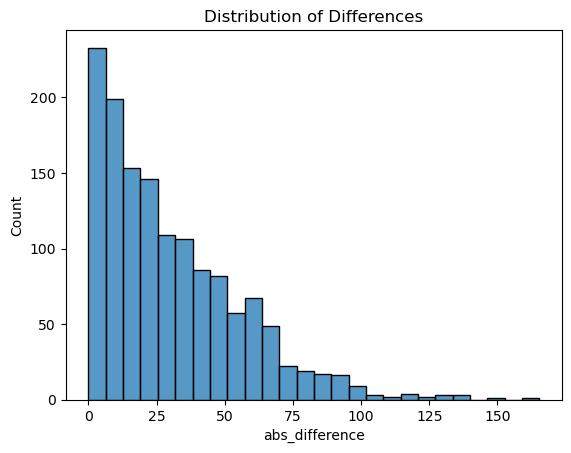

In [67]:
sns.histplot(results.abs_difference)
plt.title('Distribution of Differences');

### Create DataFrame of the best results where the pick was projected within 16 picks

In [68]:
best = results[results.abs_difference <= 16]

In [69]:
best

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,well,work,yard,year,year starter,zone,0,1,difference,abs_difference
1,3550,Julian Okwara,3550,3,3550,2020.0,3550,252.0,76.250,6.0,...,0,0,0,0,0,0,75.619732,66,8.619732,8.619732
2,2556,Cody Whitehair,2556,2,2556,2016.0,2556,301.0,75.750,2.0,...,0,0,0,0,0,0,61.437897,55,5.437897,5.437897
3,4021,Breece Hall,4021,2,4021,2022.0,4021,NaN,NaN,1.0,...,0,0,0,0,0,0,34.534121,35,-1.465879,1.465879
5,3731,Ja'Marr Chase,3731,1,3731,2021.0,3731,201.0,72.375,1.0,...,0,0,1,0,0,0,9.276554,4,4.276554,4.276554
6,2133,DaQuan Jones,2133,4,2133,2014.0,2133,322.0,75.750,7.0,...,0,0,0,0,0,0,98.589089,111,-13.410911,13.410911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,3051,Derrius Guice,3051,2,3051,2018.0,3051,224.0,70.500,4.0,...,0,0,2,0,0,0,43.282406,58,-15.717594,15.717594
1384,1429,Shareece Wright,1429,3,1429,2011.0,1429,185.0,70.875,12.0,...,0,0,0,0,0,0,91.696668,88,2.696668,2.696668
1385,1078,Ra'Shon Harris,1078,6,1078,2009.0,1078,298.0,75.750,24.0,...,0,1,0,0,0,0,191.112837,204,-13.887163,13.887163
1387,3136,Bilal Nichols,3136,5,3136,2018.0,3136,306.0,75.750,16.0,...,0,0,0,0,0,0,157.633561,144,12.633561,12.633561


### Create DataFrame of the worst results where the pick was projected more than 64 picks away

In [70]:
worst = results[results.abs_difference >= 64]

### Normalized counts of players that were the best and worst by round

In [71]:
best.Round_col.value_counts(normalize=True)

1    0.246154
2    0.198077
6    0.173077
5    0.130769
3    0.123077
4         0.1
7    0.028846
Name: Round_col, dtype: Float64

In [72]:
worst.Round_col.value_counts(normalize=True)

7     0.29932
3    0.292517
4    0.129252
2    0.115646
6    0.088435
5    0.068027
1    0.006803
Name: Round_col, dtype: Float64

The Model was best at predicting players in round 1 and was worst at projecting players in round 3 and 7

### Position Breakdown of the model's best and worst projections

In [73]:
# Count of the normalized best position minus the actual position breakdown
best_pos = best.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)

# Count of the normalized worst position minus the actual position breakdown
worst_pos = worst.pos_col.value_counts(normalize=True) - results.pos_col.value_counts(normalize=True)

In [74]:
best_pos.sort_values(ascending=False)

QB    0.010423
RB    0.008311
OL    0.005596
WR    0.005490
DE    0.003992
DT    0.003035
TE    0.002740
P     0.000246
FB   -0.000237
K    -0.001193
DL   -0.003117
DB   -0.003662
S    -0.007397
CB   -0.007852
LB   -0.014935
LS         NaN
Name: pos_col, dtype: float64

In [75]:
worst_pos.sort_values(ascending=False)

DT    0.039979
S     0.028827
CB    0.019791
QB    0.003306
WR    0.002939
K     0.001763
DB   -0.000588
DE   -0.004760
OL   -0.005995
RB   -0.014046
LB   -0.029312
TE   -0.029665
DL         NaN
FB         NaN
LS         NaN
P          NaN
Name: pos_col, dtype: float64

The model was best at predicting WR and DEs while it struggled with OL, S, CB, and DB. 3 of the 4 worst positions were all the secondary positions.

In [76]:
# Breakdown of the positions that were the best in the first round
best.pos_col[best.Round_col == 1].value_counts(normalize=True) - results.pos_col[results.Round_col == 1].value_counts(normalize=True)

CB   -0.013445
DB   -0.018895
DE    0.002907
DL         NaN
DT    0.008539
LB   -0.007267
OL   -0.017624
QB   -0.000908
RB    0.018169
S     0.001999
TE    0.009993
WR    0.022347
Name: pos_col, dtype: float64

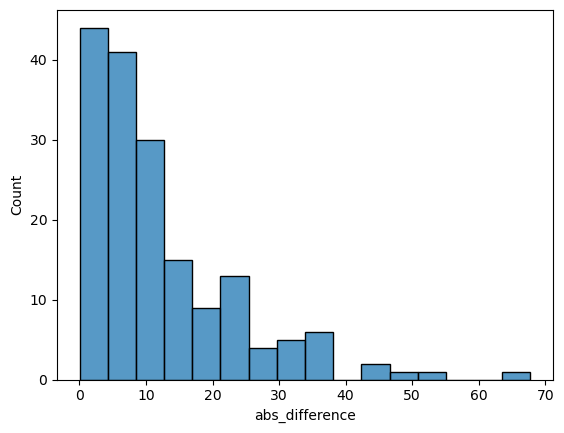

In [77]:
sns.histplot(results[results.Round_col == 1].abs_difference);

### Checking how the word develop appears in round 1 and when the difference is greater than 32

In [78]:
one_round = results[results.Round_col == 1]

In [79]:
one_miss = one_round[one_round.abs_difference > 20]

In [80]:
results[results.Round_col == 2].sort_values(by='abs_difference')

,index,player_col,index,Round_col,index,year_col,index,weight_x_col,height_x_col,pos_rk_col,...,well,work,yard,year,year starter,zone,0,1,difference,abs_difference
85,705,Quentin Groves,705,2,705,2008.0,705,259.0,75.000,6.0,...,0,0,0,1,0,0,52.117419,51,0.117419,0.117419
341,915,Eben Britton,915,2,915,2009.0,915,309.0,78.000,5.0,...,0,1,0,0,0,0,39.237727,38,0.237727,0.237727
912,3288,Erik McCoy,3288,2,3288,2019.0,3288,303.0,75.875,2.0,...,1,0,0,0,0,0,47.561929,47,-0.438071,0.438071
1300,925,Max Unger,925,2,925,2009.0,925,309.0,76.625,3.0,...,0,1,0,0,0,0,49.874571,48,0.874571,0.874571
1083,4030,David Ojabo,4030,2,4030,2022.0,4030,NaN,NaN,1.0,...,0,0,0,0,0,0,44.109205,44,-0.890795,0.890795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,3540,Van Jefferson,3540,2,3540,2020.0,3540,200.0,73.500,18.0,...,0,0,2,0,0,1,146.876459,56,89.876459,89.876459
806,1402,Jonas Mouton,1402,2,1402,2011.0,1402,239.0,73.000,11.0,...,0,0,0,0,0,0,155.539009,60,94.539009,94.539009
1348,2317,Jordan Richards,2317,2,2317,2015.0,2317,211.0,70.750,16.0,...,2,0,0,1,1,0,175.830845,63,111.830845,111.830845
537,1618,Tavon Wilson,1618,2,1618,2012.0,1618,203.0,72.000,24.0,...,0,0,0,0,0,0,187.036269,47,139.036269,139.036269


In [81]:
one_miss[['player_col','Round_col','year_col','pos_col','ovr_rk_col','pos_rk_col','grade_col','difference',0,1]]

,player_col,Round_col,year_col,pos_col,ovr_rk_col,pos_rk_col,grade_col,difference,0,1
35,Tamba Hali,1,2006.0,DE,40.0,6.0,87.0,33.552413,53.552413,19
57,David Wilson,1,2012.0,RB,52.0,3.0,84.0,26.832105,58.832105,31
122,James Carpenter,1,2011.0,OL,43.0,2.0,85.0,24.489636,49.489636,24
190,Nick Perry,1,2012.0,DE,38.0,6.0,88.0,24.023542,52.023542,27
199,Joe Tryon,1,2021.0,LB,37.0,4.0,88.0,22.110978,54.110978,31
208,Antoine Cason,1,2008.0,DB,42.0,7.0,86.0,25.178046,52.178046,26
216,A.J. Jenkins,1,2012.0,WR,62.0,7.0,82.0,37.780963,67.780963,29
243,Payton Turner,1,2021.0,DE,73.0,9.0,76.0,50.805327,78.805327,27
271,Eric Stokes,1,2021.0,DB,71.0,10.0,76.0,44.225769,73.225769,28
333,Gregory Rousseau,1,2021.0,DL,48.0,7.0,84.0,22.479574,52.479574,29


In [82]:
miss_one = one_round[one_round.abs_difference > 32]

In [83]:
miss_one.develop.mean()

0.2

In [84]:
one_round.develop.mean()

0.2616279069767442

### Average Differences by Round

In [85]:
results[results.Round_col == 1].abs_difference.mean()

12.118527080102625

In [86]:
results[results.Round_col == 2].abs_difference.mean()

23.14137566733043

In [87]:
results[results.Round_col == 3].abs_difference.mean()

36.35643542884378

In [88]:
results[results.Round_col == 4].abs_difference.mean()

34.78282756812156

In [89]:
results[results.Round_col == 5].abs_difference.mean()

27.24064137988444

In [90]:
results[results.Round_col == 6].abs_difference.mean()

25.88292739739088

In [91]:
results[results.Round_col == 7].abs_difference.mean()

51.55501680336182

### Breakdown of features by Pos

In [92]:
cleaned_df[cleaned_df.Round_col == 1].groupby('pos_col').mean().sort_values(by='ovr_rk_col')

,year_col,weight_x_col,height_x_col,pos_rk_col,ovr_rk_col,grade_col,age_col,Round_col,Pick_col,target_col,...,tackles_assists_career_col,tackles_total_career_col,tackles_loss_career_col,sacks_career_col,pass_defended_career_col,fumbles_forced_season_col,fumbles_forced_career_col,speed_col,shuttle_agility_col,cone_agility_col
pos_col,,,,,,,,,,,,,,,,,,,,,
TE,2012.875000,251.062500,76.695312,1.312500,17.062500,91.625000,22.125000,1.0,20.3125,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.666030,144.407558,145.712496
DT,2013.204082,308.595745,75.111702,2.714286,17.489796,91.795918,22.083333,1.0,17.081633,3.0,...,54.066667,114.133333,22.888889,9.444444,4.388889,1.736842,2.379310,97.849975,136.961771,143.358176
DE,2012.900000,270.151515,76.119318,2.914286,17.871429,91.814286,22.014493,1.0,15.742857,3.0,...,49.812500,118.468750,32.085938,18.460938,5.000000,2.500000,3.877193,109.577507,148.839163,146.681849
QB,2013.962264,226.826923,75.509615,2.471698,18.264151,91.452830,22.134615,1.0,9.90566,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.558852,137.959072,133.613383
RB,2011.444444,217.138889,70.961806,2.111111,18.833333,92.083333,21.735294,1.0,17.138889,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.335770,132.875457,127.253084
WR,2014.043478,205.095238,73.043651,3.362319,20.057971,90.869565,21.692308,1.0,17.347826,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.740370,129.574828,123.432178
LB,2013.868852,244.793103,74.413793,2.344262,21.344262,90.590164,21.983333,1.0,16.836066,3.0,...,83.962963,196.481481,27.861111,12.000000,6.063830,2.451613,4.125000,110.896430,156.247868,141.032109
DB,2010.619048,199.245902,70.651639,2.741935,22.225806,91.387097,22.129032,1.0,18.936508,3.0,...,49.471698,159.037736,8.650943,2.208333,15.086957,1.444444,2.047619,103.610605,140.182586,126.084150
OL,2014.135922,313.936170,77.140957,2.553398,23.339806,90.126214,22.274510,1.0,16.834951,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.208684,133.981217,138.969886
